In [1]:
machine = 'mac'
machine = 'magny'

In [2]:
from galpy.potential import NFWPotential as NFWpot
from galpy.potential import HernquistPotential as HEpot
from galpy.potential import DoubleExponentialDiskPotential as DEpot
from galpy.potential import MiyamotoNagaiPotential as MNpot
from galpy.potential import MN3ExponentialDiskPotential as MN3pot
from galpy.potential import MWPotential2014

from galpy.potential import evaluateDensities, evaluatePotentials
from galpy.potential import plotDensities
from galpy.potential import plotRotcurve
from galpy.util import bovy_conversion

import numpy as np
from scipy import optimize as opt

from astropy import units

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import copy

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind
import calcGrid

from auriga_basics import *
from auriga_functions import *

%matplotlib inline

/home/extmilan/anaconda3/lib/python3.6/site-packages/galpy-1.3.dev0-py3.6-linux-x86_64.egg/galpy/potential_src/TwoPowerSphericalPotential.py:186: RuntimeWarning: divide by zero encountered in double_scalars
  return (self.a/r)**self.alpha/(1.+r/self.a)**(self.beta-self.alpha)/4./m.pi/self.a**3.

/home/extmilan/anaconda3/lib/python3.6/site-packages/numpy/core/function_base.py:128: RuntimeWarning: invalid value encountered in multiply
  y = y * step

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1176: RuntimeWarning: invalid value encountered in greater
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1176: RuntimeWarning: invalid value encountered in less
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)

/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  wa

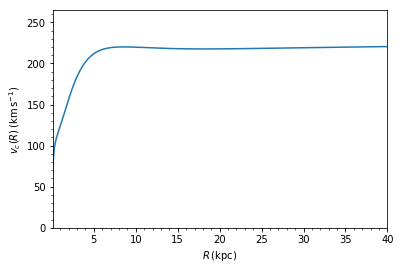

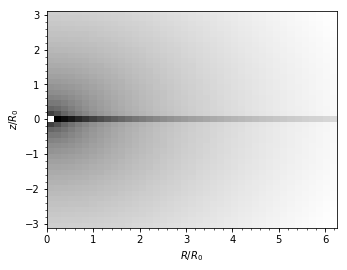

In [3]:
# galpy playtime


r0 = 8.
v0 = 220.

a_mp = 0.5 
b_mp = 0.0375 
n_mp = 0.6  
a_nfw = 4.5 
n_nfw = 0.35 
a_he = 0.6 / 8. 
n_he = 0.05 
mp = MNpot(a = a_mp, b = b_mp, normalize = n_mp, ro = r0, vo = v0)
nfwp = NFWpot(a = a_nfw, normalize = n_nfw, ro = r0, vo = v0)
hep = HEpot(a = a_he, normalize = 1-(n_mp+n_nfw), ro = r0, vo = v0)
   
mp.turn_physical_on()
nfwp.turn_physical_on()
hep.turn_physical_on()
pot = [mp,nfwp,hep]

plotRotcurve(pot)
plotDensities(pot, rmin = 0. * units.kpc, rmax = 50. * units.kpc, zmin = -25. * units.kpc, \
              zmax = 25. * units.kpc, log = True, nrs = 41, nzs = 41)


In [4]:
#### path = /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/*
level = 4
if machine == 'magny':
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
elif machine == 'mac': 
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
j = 0
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    for snapnr in range(127,128,1):
        print("level   : {0}".format(level))
        print("halo    : {0}".format(halo_number))
        print("snapnr  : {0}".format(snapnr))
        print("basedir : {0}".format(basedir))
        print("halodir : {0}".format(halodir))
        print("snappath: {0}\n".format(snappath))
        s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[0,1,2,3,4,5], 
            haloid=0, galradfac=0.1, verbose=True) 

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )
     

level   : 4
halo    : 24
snapnr  : 127
basedir : /hits/universe/GigaGalaxy/level4_MHD/
halodir : /hits/universe/GigaGalaxy/level4_MHD/halo_24/
snappath: /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/

[ 34.42281723  33.16259384  37.29567337]
Found 1783163 stars.
Rotated pos.
Rotated bfld.
Rotated vel.

galrad  : 0.02408556640148163
redshift: 2.220446049250313e-16
time    : 0.9999999999999998
center  : [ 0.  0.  0.]



In [17]:
iall, = np.where( (s.halo == 0) & (s.r() < s.galrad) & (s.r() > 0.) )
igas, = np.where( (s.halo == 0) & (s.r() < s.galrad) & (s.r() > 0.) & (s.type == 0) )
idm, = np.where( (s.halo == 0) & (s.r() < s.galrad) & (s.r() > 0.) & ((s.type == 1) + (s.type == 2) + (s.type == 3) ))
istars, = np.where( (s.halo == 0) & (s.r() <s.galrad) & (s.r() > 0.) & (s.type == 4) )
mask = iall    

(x_kpc, y_kpc, z_kpc), (vx_kms, vy_kms, vz_kms), rxyz_kpc, rxy_kpc = get_cartesian_vectors(s, sf, mask)
(R_kpc, phi, z_kpc), (vR_kms, vphi, vz_kms) = get_cylindrical_vectors(s, sf, mask)


(x, y, z), (vx, vy, vz), rxyz, rxy = get_cartesian_vectors(s, sf, mask)
(R, phi, z), (vR, vphi, vz) = get_cylindrical_vectors(s, sf, mask)

#rho, Rbin, z, vol = fitting_dens(s.mass[mask][np.abs(z_kpc > -50.) & np.abs(z_kpc <50.)], R_kpc[np.abs(z_kpc > -50.) & np.abs(z_kpc <50.)], z_kpc[np.abs(z_kpc > -50.) & np.abs(z_kpc <50.)], nbins = 41)
#rho, R, z, vol = fitting_dens(s)
r_dm_kpc = 1000. * s.r()[idm]
(R_dm_kpc, phi, z_dm_kpc), (vR, vphi, vz) = get_cylindrical_vectors(s, sf, idm)
r_gas_kpc = 1000. * s.r()[igas]
r_stars_kpc = 1000. * s.r()[istars]
r_all_kpc = 1000. * s.r()[iall]
pot_dm = s.pot[idm]
pot_m_dm = s.pot[idm] * s.mass[idm]
pot_gas = s.pot[igas]
pot_stars = s.pot[istars]
pot_all = s.pot[iall]


Text(0,0.5,'pot [??]')

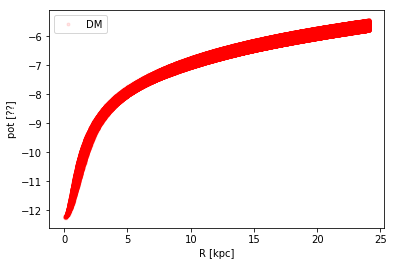

In [18]:
#plt.plot(r_stars_kpc, pot_stars, 'b.', alpha = 0.01, label = 'stars')
#plt.plot(r_gas_kpc, pot_gas, 'g.', alpha = 0.01, label = 'gas')
plt.plot(r_dm_kpc, pot_m_dm, 'r.', alpha = 0.1, label = 'DM') 
plt.legend()
plt.xlabel('R [kpc]')
plt.ylabel('pot [??]')

In [19]:
#dm particle (random) selection

import random
a = np.array(random.sample(list(enumerate(pot_m_dm)), 50))
rand_ind = a[:,0].astype(int)
rand_pot_dm = a[:, 1]
rand_r_dm = r_dm_kpc[rand_ind]
rand_R_dm = R_dm_kpc[rand_ind]
rand_z_dm = z_dm_kpc[rand_ind]
print(rand_pot_dm)

[ -6.87155294  -8.58561707  -7.38194752  -7.15894079  -7.0581398
 -11.8293047   -6.22981405  -6.20125866  -7.56855297  -6.43051004
  -6.72469187  -6.20183277  -6.99826813  -6.57191086  -5.92261934
  -6.88390303  -5.77636862  -5.88795376  -6.94335365  -8.88483047
  -5.96911669  -7.38313723  -5.80615568  -5.69643021  -5.76000023
  -6.50216913  -6.3904376   -9.98584843  -5.86928606  -6.3164959
  -5.73288536  -6.80112076  -6.76332951  -6.09745741  -7.38324356
  -8.82607174 -10.54043484  -6.25181723  -6.12462473  -5.85037899
  -7.09575939  -5.7557354   -6.62282372  -6.54163694 -11.29268742
  -5.59528351  -6.98286247  -7.24969196  -5.57790804  -7.80481863]


In [21]:
### finde nen Weg um das ganze von klein r abhängig zu machen 
### finde sinnvolle Standartwerte für Initialisierungs Parameter
### eventuell nur dens ODER pot ausgeben, hängt von Fit funktion ab 
### ravel works in the way I want?


#def galpy_fitting(r, R, z, r0, v0, a_mp = 0.5, b_mp = 0.0375, n_mp = 0.6, a_nfw = 4.5, n_nfw = 0.35, \
#                  a_he = 0.6 / 8., n_he = 0.05, hr_de = 0.3333333333333333, hz_de = 0.0625, \
#                  dens_fit = True, pot_fit = False):
 
def galpy_fitting(a_mp, b_mp, n_mp, a_nfw, n_nfw, a_he, v0,\
                  r = None, R = None, z = None, r0 = None):    
    
    # stell sicher dass n_mp + n_nfw + n_he = 1, zb mit 
    n_he = 1. - (n_mp + n_nfw)
    mp = MNpot(a = a_mp, b = b_mp, normalize = n_mp)
    nfwp = NFWpot(a = a_nfw, normalize = n_nfw)
    hep = HEpot(a = a_he * units.kpc, normalize = n_he)
    pot = [mp, nfwp, hep]         
    pot_mod = np.zeros((len(z), len(R)))
    for ii, zii in enumerate(z):
        for jj, Rjj in enumerate(R):
            pot_mod[ii, jj] = evaluatePotentials(pot, Rjj, zii)
    return pot_mod

# FITTING

def RMS(x, r, R, z, N, pot, r0):
    a_mp, b_mp, n_mp, a_nfw, n_nfw, a_he, v0 = x[0], x[1], x[2], x[3], x[4], x[5], x[6]
    ydata = pot
    ymodel = galpy_fitting(a_mp, b_mp, n_mp, a_nfw, n_nfw, a_he, v0, r, R, z, r0)
    RMS = np.sqrt(1./N*np.sum((ydata - ymodel)**2))
    print(RMS)
    print(a_mp, b_mp, n_mp, a_nfw, n_nfw, a_he, v0)
    return RMS

a_mp = 0.5 
b_mp = 0.1#0.0375 
n_mp = 0.6  
a_nfw = 3 #4.5 
n_nfw = 0.35 
a_he = 0.6 / 8. 
n_he = 0.05 
hr_de = 0.3 
hz_de = 0.0625
v0 = 200.

pot = rand_pot_dm
r, R, z = rand_r_dm, rand_R_dm, rand_z_dm
x0 = (a_mp, b_mp, n_mp,  a_nfw , n_nfw , a_he, v0) #n_he

bounds = ((0., None), (0., None), (0., 1.), (0., None), (0., 1.), (0., None), (0., None)) #n_he
#r, R, z, rho = R, Rbin, z, rho
#rho, R, z, vol = fitting_dens(s)

r0 = 8.
N = len(r)
# v0 muss mitgefittet werden
print(x0)
res = opt.minimize(RMS, x0 = x0, args= (r, R, z, N, pot, r0), bounds = bounds)


(0.5, 0.1, 0.6, 3, 0.35, 0.075, 200.0)
40.3770516174
0.5 0.1 0.6 3.0 0.35 0.075 200.0
40.3770516089
0.50000001 0.1 0.6 3.0 0.35 0.075 200.0
40.3770516079
0.5 0.10000001 0.6 3.0 0.35 0.075 200.0
40.3770516138
0.5 0.1 0.60000001 3.0 0.35 0.075 200.0
40.3770515837
0.5 0.1 0.6 3.00000001 0.35 0.075 200.0
40.3770513674
0.5 0.1 0.6 3.0 0.35000001 0.075 200.0
40.3770516173
0.5 0.1 0.6 3.0 0.35 0.07500001 200.0
40.3770516174
0.5 0.1 0.6 3.0 0.35 0.075 200.00000001
30.4342171138
0.729977792307 0.358208712506 0.697928026724 3.91630520392 0.526713679192 0.0773719744984 200.0
30.4342170926
0.729977802307 0.358208712506 0.697928026724 3.91630520392 0.526713679192 0.0773719744984 200.0
30.4342170913
0.729977792307 0.358208722506 0.697928026724 3.91630520392 0.526713679192 0.0773719744984 200.0
30.4342170995
0.729977792307 0.358208712506 0.697928036724 3.91630520392 0.526713679192 0.0773719744984 200.0
30.434217061
0.729977792307 0.358208712506 0.697928026724 3.91630521392 0.526713679192 0.0773719744

8.97754466288
0.654594493095 0.300942060781 0.385455033183 5.55924356374 0.95460560432 0.0913655671569 200.0
8.97754466334
0.654594483095 0.300942070781 0.385455033183 5.55924356374 0.95460560432 0.0913655671569 200.0
8.97754466337
0.654594483095 0.300942060781 0.385455043183 5.55924356374 0.95460560432 0.0913655671569 200.0
8.97754468146
0.654594483095 0.300942060781 0.385455033183 5.55924357374 0.95460560432 0.0913655671569 200.0
8.9775447933
0.654594483095 0.300942060781 0.385455033183 5.55924356374 0.95460561432 0.0913655671569 200.0
8.97754465759
0.654594483095 0.300942060781 0.385455033183 5.55924356374 0.95460560432 0.0913655771569 200.0
8.97754465788
0.654594483095 0.300942060781 0.385455033183 5.55924356374 0.95460560432 0.0913655671569 200.00000001
8.86505990046
0.773945040372 0.42771306871 0.512140884813 5.49806069948 0.927035154552 0.0883277721434 200.0
8.86505990657
0.773945050372 0.42771306871 0.512140884813 5.49806069948 0.927035154552 0.0883277721434 200.0
8.86505990704

7.98870978464
0.0 0.0 0.128975413306 8.2251918797 0.5888257784 0.146730404814 200.0
7.98870984621
0.0 0.0 0.128975413306 8.2251918697 0.5888257884 0.146730404814 200.0
7.98870978062
0.0 0.0 0.128975413306 8.2251918697 0.5888257784 0.146730414814 200.0
7.98870978052
0.0 0.0 0.128975413306 8.2251918697 0.5888257784 0.146730404814 200.00000001
8.096438247
0.0 0.0 0.235711731675 9.5087379076 0.469561229604 0.17277504698 200.0
8.09643824713
1e-08 0.0 0.235711731675 9.5087379076 0.469561229604 0.17277504698 200.0
8.096438247
0.0 1e-08 0.235711731675 9.5087379076 0.469561229604 0.17277504698 200.0
8.09643824705
0.0 0.0 0.235711741675 9.5087379076 0.469561229604 0.17277504698 200.0
8.09643823132
0.0 0.0 0.235711731675 9.5087379176 0.469561229604 0.17277504698 200.0
8.09643799002
0.0 0.0 0.235711731675 9.5087379076 0.469561239604 0.17277504698 200.0
8.09643824689
0.0 0.0 0.235711731675 9.5087379076 0.469561229604 0.17277505698 200.0
8.096438247
0.0 0.0 0.235711731675 9.5087379076 0.469561229604

7.69068849936
0.0 1e-08 0.751249301343 12.65301591 0.348012866108 0.238170913383 200.0
7.69068849939
0.0 0.0 0.751249311343 12.65301591 0.348012866108 0.238170913383 200.0
7.6906884961
0.0 0.0 0.751249301343 12.65301592 0.348012866108 0.238170913383 200.0
7.69068840291
0.0 0.0 0.751249301343 12.65301591 0.348012876108 0.238170913383 200.0
7.69068849937
0.0 0.0 0.751249301343 12.65301591 0.348012866108 0.238170923383 200.0
7.69068849936
0.0 0.0 0.751249301343 12.65301591 0.348012866108 0.238170913383 200.00000001
7.68494613814
0.0 0.0 0.661098207228 12.1012000156 0.369772033743 0.226862349791 200.0
7.68494613849
1e-08 0.0 0.661098207228 12.1012000156 0.369772033743 0.226862349791 200.0
7.68494613814
0.0 1e-08 0.661098207228 12.1012000156 0.369772033743 0.226862349791 200.0
7.68494613814
0.0 0.0 0.661098217228 12.1012000156 0.369772033743 0.226862349791 200.0
7.68494613727
0.0 0.0 0.661098207228 12.1012000256 0.369772033743 0.226862349791 200.0
7.68494612106
0.0 0.0 0.661098207228 12.101

7.65768669222
1e-08 0.0 0.989263428365 14.3789323586 0.303544945287 0.272899887823 200.0
7.65768669144
0.0 1e-08 0.989263428365 14.3789323586 0.303544945287 0.272899887823 200.0
7.65768669146
0.0 0.0 0.989263438365 14.3789323586 0.303544945287 0.272899887823 200.0
7.65768669143
0.0 0.0 0.989263428365 14.3789323686 0.303544945287 0.272899887823 200.0
7.65768669089
0.0 0.0 0.989263428365 14.3789323586 0.303544955287 0.272899887823 200.0
7.65768669146
0.0 0.0 0.989263428365 14.3789323586 0.303544945287 0.272899897823 200.0
7.65768669144
0.0 0.0 0.989263428365 14.3789323586 0.303544945287 0.272899887823 200.00000001
7.65767773344
0.0 0.0 0.982865642674 14.3961134895 0.303160321867 0.273239379656 200.0
7.65767773421
1e-08 0.0 0.982865642674 14.3961134895 0.303160321867 0.273239379656 200.0
7.65767773344
0.0 1e-08 0.982865642674 14.3961134895 0.303160321867 0.273239379656 200.0
7.65767773345
0.0 0.0 0.982865652674 14.3961134895 0.303160321867 0.273239379656 200.0
7.65767773345
0.0 0.0 0.9828

7.65627642589
0.0 0.0 0.0 14.5065856586 0.30017758568 0.275029645302 200.0
7.65627642589
0.0 0.0 0.0 14.5065856586 0.30017757568 0.275029655302 200.0
7.65627642593
0.0 0.0 0.0 14.5065856586 0.30017757568 0.275029645302 200.00000001
7.65627636908
0.0 0.0 0.0 14.5057880294 0.300200403144 0.275032987354 200.0
7.65627636908
1e-08 0.0 0.0 14.5057880294 0.300200403144 0.275032987354 200.0
7.65627636908
0.0 1e-08 0.0 14.5057880294 0.300200403144 0.275032987354 200.0
7.6562763691
0.0 0.0 1e-08 14.5057880294 0.300200403144 0.275032987354 200.0
7.65627636909
0.0 0.0 0.0 14.5057880394 0.300200403144 0.275032987354 200.0
7.65627636918
0.0 0.0 0.0 14.5057880294 0.300200413144 0.275032987354 200.0
7.65627636905
0.0 0.0 0.0 14.5057880294 0.300200403144 0.275032997354 200.0
7.65627636908
0.0 0.0 0.0 14.5057880294 0.300200403144 0.275032987354 200.00000001
7.65627631913
0.0 0.0 0.0 14.5054464295 0.300210611533 0.275047738152 200.0
7.65627631913
1e-08 0.0 0.0 14.5054464295 0.300210611533 0.275047738152 

7.65034836798
0.0 0.0 7.54435437875e-06 14.4438113211 0.300034679088 3.42898167804 200.0
7.65034836798
1e-08 0.0 7.54435437875e-06 14.4438113211 0.300034679088 3.42898167804 200.0
7.65034836798
0.0 1e-08 7.54435437875e-06 14.4438113211 0.300034679088 3.42898167804 200.0
7.65034836786
0.0 0.0 7.55435437875e-06 14.4438113211 0.300034679088 3.42898167804 200.0
7.65034836888
0.0 0.0 7.54435437875e-06 14.4438113311 0.300034679088 3.42898167804 200.0
7.65034840889
0.0 0.0 7.54435437875e-06 14.4438113211 0.300034689088 3.42898167804 200.0
7.650348368
0.0 0.0 7.54435437875e-06 14.4438113211 0.300034679088 3.42898168804 200.0
7.65034836798
0.0 0.0 7.54435437875e-06 14.4438113211 0.300034679088 3.42898167804 200.00000001
7.6363226299
0.0 0.0 0.000160078215045 16.0582625919 0.255610122451 10.0679849115 200.0
7.6363226299
1e-08 0.0 0.000160078215045 16.0582625919 0.255610122451 10.0679849115 200.0
7.6363226299
0.0 1e-08 0.000160078215045 16.0582625919 0.255610122451 10.0679849115 200.0
7.636322630

7.61772886138
1e-08 0.0 0.0 19.2250919195 0.202688043034 13.9269700096 200.0
7.61772886138
0.0 1e-08 0.0 19.2250919195 0.202688043034 13.9269700096 200.0
7.6177288629
0.0 0.0 1e-08 19.2250919195 0.202688043034 13.9269700096 200.0
7.61772886021
0.0 0.0 0.0 19.2250919295 0.202688043034 13.9269700096 200.0
7.61772876996
0.0 0.0 0.0 19.2250919195 0.202688053034 13.9269700096 200.0
7.61772886127
0.0 0.0 0.0 19.2250919195 0.202688043034 13.9269700196 200.0
7.61772886138
0.0 0.0 0.0 19.2250919195 0.202688043034 13.9269700096 200.00000001
7.61512181554
0.0 0.0 0.0 18.7075559891 0.210767730103 13.3321094679 200.0
7.61512181554
1e-08 0.0 0.0 18.7075559891 0.210767730103 13.3321094679 200.0
7.61512181554
0.0 1e-08 0.0 18.7075559891 0.210767730103 13.3321094679 200.0
7.61512181614
0.0 0.0 1e-08 18.7075559891 0.210767730103 13.3321094679 200.0
7.61512181496
0.0 0.0 0.0 18.7075559991 0.210767730103 13.3321094679 200.0
7.61512177579
0.0 0.0 0.0 18.7075559891 0.210767740103 13.3321094679 200.0
7.61512

7.59716285606
0.0 0.0 0.0 23.1077604011 0.161496863312 17.1610363668 200.0
7.59716286929
0.0 0.0 0.0 23.1077604011 0.161496853312 17.1610363768 200.0
7.59716286931
0.0 0.0 0.0 23.1077604011 0.161496853312 17.1610363668 200.00000001
7.61305758353
0.0 0.0 0.0 25.0219526761 0.14375619553 18.9123440402 200.0
7.61305758353
1e-08 0.0 0.0 25.0219526761 0.14375619553 18.9123440402 200.0
7.61305758353
0.0 1e-08 0.0 25.0219526761 0.14375619553 18.9123440402 200.0
7.61305758787
0.0 0.0 1e-08 25.0219526761 0.14375619553 18.9123440402 200.0
7.61305758207
0.0 0.0 0.0 25.0219526861 0.14375619553 18.9123440402 200.0
7.6130573644
0.0 0.0 0.0 25.0219526761 0.14375620553 18.9123440402 200.0
7.61305758328
0.0 0.0 0.0 25.0219526761 0.14375619553 18.9123440502 200.0
7.61305758353
0.0 0.0 0.0 25.0219526761 0.14375619553 18.9123440402 200.00000001
7.59631883227
0.0 0.0 0.0 23.5551611129 0.157350361331 17.5703663541 200.0
7.59631883227
1e-08 0.0 0.0 23.5551611129 0.157350361331 17.5703663541 200.0
7.5963188322

7.65022367045
0.0 0.0 0.0 33.218147475 0.100390736597 22.1876294628 200.0
7.65022367045
1e-08 0.0 0.0 33.218147475 0.100390736597 22.1876294628 200.0
7.65022367045
0.0 1e-08 0.0 33.218147475 0.100390736597 22.1876294628 200.0
7.65022368043
0.0 0.0 1e-08 33.218147475 0.100390736597 22.1876294628 200.0
7.65022366864
0.0 0.0 0.0 33.218147485 0.100390736597 22.1876294628 200.0
7.65022313245
0.0 0.0 0.0 33.218147475 0.100390746597 22.1876294628 200.0
7.65022366993
0.0 0.0 0.0 33.218147475 0.100390736597 22.1876294728 200.0
7.65022367045
0.0 0.0 0.0 33.218147475 0.100390736597 22.1876294628 200.00000001
7.58362704446
0.0 0.0 0.0 30.3398637037 0.114234882251 21.904324881 200.0
7.58362704446
1e-08 0.0 0.0 30.3398637037 0.114234882251 21.904324881 200.0
7.58362704446
0.0 1e-08 0.0 30.3398637037 0.114234882251 21.904324881 200.0
7.58362704476
0.0 0.0 1e-08 30.3398637037 0.114234882251 21.904324881 200.0
7.58362704449
0.0 0.0 0.0 30.3398637137 0.114234882251 21.904324881 200.0
7.58362705091
0.0 0

7.57924764339
0.0 0.0 0.0 34.449867289 0.0967460964781 24.2097031642 200.0
7.57924759547
0.0 0.0 0.0 34.449867279 0.0967461064781 24.2097031642 200.0
7.5792476435
0.0 0.0 0.0 34.449867279 0.0967460964781 24.2097031742 200.0
7.57924764355
0.0 0.0 0.0 34.449867279 0.0967460964781 24.2097031642 200.00000001
7.57873815158
0.0 0.0 0.0 34.3159154894 0.0970122558345 24.5240736025 200.0
7.57873815158
1e-08 0.0 0.0 34.3159154894 0.0970122558345 24.5240736025 200.0
7.57873815158
0.0 1e-08 0.0 34.3159154894 0.0970122558345 24.5240736025 200.0
7.57873815203
0.0 0.0 1e-08 34.3159154894 0.0970122558345 24.5240736025 200.0
7.57873815152
0.0 0.0 0.0 34.3159154994 0.0970122558345 24.5240736025 200.0
7.57873813495
0.0 0.0 0.0 34.3159154894 0.0970122658345 24.5240736025 200.0
7.57873815156
0.0 0.0 0.0 34.3159154894 0.0970122558345 24.5240736125 200.0
7.57873815158
0.0 0.0 0.0 34.3159154894 0.0970122558345 24.5240736025 200.00000001
7.5782363783
0.0 0.0 0.0 34.8799831851 0.0947738249309 25.0475304196 200.

7.57436508423
0.0 0.0 0.0 41.816317599 0.0758056109606 27.5442326102 200.00000001
7.57341652803
0.0 0.0 0.0 41.7711273531 0.0757008517255 27.5018110529 200.0
7.57341652803
1e-08 0.0 0.0 41.7711273531 0.0757008517255 27.5018110529 200.0
7.57341652803
0.0 1e-08 0.0 41.7711273531 0.0757008517255 27.5018110529 200.0
7.57341652797
0.0 0.0 1e-08 41.7711273531 0.0757008517255 27.5018110529 200.0
7.57341652803
0.0 0.0 0.0 41.7711273631 0.0757008517255 27.5018110529 200.0
7.57341652862
0.0 0.0 0.0 41.7711273531 0.0757008617255 27.5018110529 200.0
7.57341652804
0.0 0.0 0.0 41.7711273531 0.0757008517255 27.5018110629 200.0
7.57341652803
0.0 0.0 0.0 41.7711273531 0.0757008517255 27.5018110529 200.00000001
7.5730260788
0.0 0.0 3.09868123689e-07 42.5628874734 0.073922266803 27.7440223573 200.0
7.5730260788
1e-08 0.0 3.09868123689e-07 42.5628874734 0.073922266803 27.7440223573 200.0
7.5730260788
0.0 1e-08 3.09868123689e-07 42.5628874734 0.073922266803 27.7440223573 200.0
7.57302607894
0.0 0.0 3.19868

7.57061171843
0.0 0.0 0.0 48.6983149953 0.0631661569404 28.577149959 200.0
7.57061173356
0.0 0.0 0.0 48.6983149953 0.0631661469404 28.577149969 200.0
7.57061173358
0.0 0.0 0.0 48.6983149953 0.0631661469404 28.577149959 200.00000001
7.57068052784
0.0 0.0 0.0 49.7380780268 0.0615085297882 28.7536350312 200.0
7.57068052784
1e-08 0.0 0.0 49.7380780268 0.0615085297882 28.7536350312 200.0
7.57068052784
0.0 1e-08 0.0 49.7380780268 0.0615085297882 28.7536350312 200.0
7.57068052916
0.0 0.0 1e-08 49.7380780268 0.0615085297882 28.7536350312 200.0
7.57068052775
0.0 0.0 0.0 49.7380780368 0.0615085297882 28.7536350312 200.0
7.57068046295
0.0 0.0 0.0 49.7380780268 0.0615085397882 28.7536350312 200.0
7.57068052779
0.0 0.0 0.0 49.7380780268 0.0615085297882 28.7536350412 200.0
7.57068052784
0.0 0.0 0.0 49.7380780268 0.0615085297882 28.7536350312 200.00000001
7.57055130767
0.0 0.0 0.0 49.1475100393 0.0624500285682 28.653394466 200.0
7.57055130767
1e-08 0.0 0.0 49.1475100393 0.0624500285682 28.653394466 2

KeyboardInterrupt: 

In [ ]:
res


In [ ]:
a_mp, b_mp, n_mp = res.x[0], res.x[1], res.x[2]
a_nfw , n_nfw = res.x[3]  , res.x[4]
a_he, n_he = res.x[5],  res.x[6]

In [ ]:
a_mp = 0.5 
b_mp = 0.0375 
n_mp = 0.6  
a_nfw = 4.5 
n_nfw = 0.35 
a_he = 0.6 / 8. 
n_he = 0.05 
mp = MNpot(a = a_mp, b = b_mp, normalize = n_mp, ro = r0, vo = v0)
nfwp = NFWpot(a = a_nfw, normalize = n_nfw, ro = r0, vo = v0)
hep = HEpot(a = a_he, normalize = 1-(n_mp+n_nfw), ro = r0, vo = v0)
    
pot = [mp,nfwp,hep]



In [ ]:
dens_final = galpy_fitting(a_mp, b_mp, n_mp, a_nfw , n_nfw, a_he, n_he, R= R, z= z)

In [ ]:
plotDensities(pot,nrs=101,nzs=101, log = True)

In [ ]:
rho.shape

In [ ]:
dens_final

In [ ]:
dens_final.shape

In [ ]:
print(rho)

In [ ]:
rho.shape

In [ ]:
plt.plot(dens_final[0, :], dens_final[1, :], '.')

In [ ]:

X, Y = np.meshgrid(R,z)
plt.contourf(X,Y, rho, norm=LogNorm(vmin=1e-6, vmax=1))
plt.show()
plt.contourf(X,Y,dens_final, norm=LogNorm(vmin=1e-6, vmax=1))

In [ ]:
print(rho)

In [ ]:
plt.imshow(rho, norm=LogNorm(vmin=1e-6, vmax=1))
plt.show()
plt.imshow(dens_final, norm=LogNorm(vmin=1e-6, vmax=1))

In [ ]:
np.max(rho)